# Image Segmentation using K-Means with Contour

### Import libraries

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math

# Make sure that optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()


True

## Step 1: Image Pre-processing

Load image, resize image to 200 x 200, and perform bilateral filter

In [3]:
#load image
img = cv.imread('img (99).png')

#Resizing Image
img = cv.resize(img, (200,200), interpolation = cv.INTER_CUBIC)

#Bilateral Filter
#Why use bilateral? -> can remove noises better than gaussian while keeping the edges sharp
img_filtered = cv.bilateralFilter(img, 7, 30, 30) 

cv.imshow('image', img)
cv.imshow('filter', img_filtered)
cv.waitKey(0)
cv.destroyAllWindows()

Convert color space to HSV and perform CLAHE on V space to enhance image contrast.

In [4]:
# Convert BGR -> HSV
img_hsv = cv.cvtColor(img_filtered, cv.COLOR_BGR2HSV)

#Spliting HSV color spaces
h,s,v = cv.split(img_hsv)

#CLAHE
clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
v_dst = clahe.apply(v)

#replacing old V space with new V space that has undergone CLAHE
img_cl = img_hsv
img_cl[:,:,2] = v_dst
img_cl = cv.cvtColor(img_cl, cv.COLOR_HSV2BGR)

cv.imshow('result',np.hstack((img,img_filtered,img_cl)))
cv.waitKey(0)
cv.destroyAllWindows()

## Step 2: K-Means segmentation

Before segmentation, need to determine K value first. Elbow graph can be used to determine the optimal K value for every input.

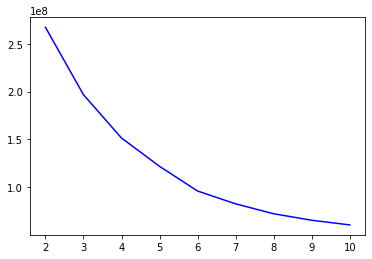

In [5]:
# k-means initial stage: Elbow method to determine optimal K value

# Convert the image to HSV
img_hsv = cv.cvtColor(img_cl, cv.COLOR_BGR2HSV)

# reshape and convert to float32
img_reshape = img_hsv.reshape((-1, 3))
img_reshape = np.float32(img_reshape)

# Define criteria, attempts and maximum k value for Elbow method graph
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10
max_k = 10

#array to store result for each k value to be plotted later
wc_sos = []

#repeat k-means segmentation until max_k value
for k in range(2, max_k+1):
    ret, _, _ = cv.kmeans(img_reshape, k, None, criteria, attempts, cv.KMEANS_PP_CENTERS)
    wc_sos.append(ret)

#plot result in graph
plt.figure()
plt.plot(list(range(2, max_k+1)), wc_sos, color = 'b')
plt.show()

How to determine optimal k?

1. plot a straight line from starting point x (2) to ending point x (10)

2. find the longest distance between the points in elbow graph and line plotted

3. x value with the longest distance will be optimum k


#### 1. plot a straight line from starting point x (2) to ending point x (10)

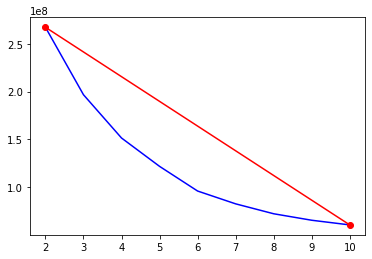

In [6]:
plt.plot(list(range(2, max_k+1)), wc_sos, color = 'b')
plt.plot([2,max_k],[wc_sos[0],wc_sos[8]],'ro-')
plt.show()

#### 2. find the longest distance between the points in elbow graph and line plotted

In [7]:
#function to find distance between a point in blue line and red line
def calc_distance(x1, y1, a, b, c):
    d = abs((a * x1 + b * y1 + c)) /(math.sqrt(a * a + b * b))
    return d

In [8]:
#(y1 - y2)x + (x2 - x1)y + (x1y2 - x2y1) = 0
# a(x) + b(y) + (c1 - c2) = 0
a = wc_sos[0] - wc_sos[8]
b = max_k - 2
c1 = 2 * wc_sos[8]
c2 = max_k * wc_sos[0]
c = c1 - c2

In [9]:
#perform calculation for all x values (2 to 10)
distance = []
idx = 0
for k in range(2, max_k+1):
    distance.append(calc_distance(k,wc_sos[idx], a, b, c))
    idx += 1

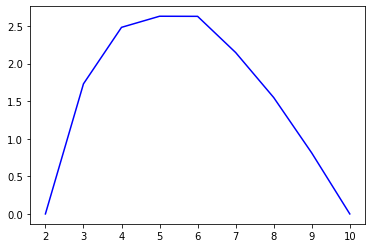

In [10]:
#visualize the result obtained from calculation
plt.plot(list(range(2, max_k+1)), distance, color = 'b')
plt.show()

#### 3. x value with the longest distance will be optimum k

In [11]:
#3. x value with the longest distance will be optimum k
K = np.argmax(distance)+2
print("Based on graph, Optimal k =",K)

Based on graph, Optimal k = 5


Instead of using K, K+1 is used as the k value as some images doesn't segment well from background when using optimal K.

In [12]:
#apply k-means segmentation according to optimal k value obtained from elbow method
ret, label, center = cv.kmeans(img_reshape, K+1, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

# Convert the center to np.uint8
center = np.uint8(center)
res = center[label.flatten()]
result = res.reshape(img_hsv.shape) 

cv.imshow('kmeans', result)
cv.waitKey(0)
cv.destroyAllWindows()

Comparison of Original Image, K-means segmented image (HSV), and K-means segmented image(BGR)

In [13]:
img_kmeans = cv.cvtColor(result, cv.COLOR_HSV2BGR)
cv.imshow('img', img)
cv.imshow('k-img', img_kmeans)
cv.imshow('kmeans', result)
cv.waitKey(0) 
cv.destroyAllWindows()

## Step 3: Contour to extract ROI


Convert k-means segmented image to grayscale image to perform Otsu thresholding.

In [14]:
#Grayscale
img_gray_kmeans = cv.cvtColor(img_kmeans, cv.COLOR_BGR2GRAY)
cv.imshow('gray', img_gray_kmeans)
cv.waitKey(0)
cv.destroyAllWindows()

In [15]:
#Otsu Thresholding
ret, th = cv.threshold(img_gray_kmeans, 0 , 255 , cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

cv.imshow('th', th)
cv.waitKey()
cv.destroyAllWindows()

Find all possible contours from thresholded image.

In [16]:
#Contour
contours, hierachy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

img_cont = img.copy()

cv.drawContours(img_cont, contours, -1, (0, 255, 0), 2)

cv.imshow('contour', img_cont)
cv.waitKey(0)
cv.destroyAllWindows() 

Extract contour which outlines the sign only.

How?

Filter out the contours according to criteria below:
1. Remove contours that are very close to the edge of display border
2. Remove contours will area smaller than threshold (Area <= 2000)

By filtering the contours, most of the noises can be cleared.

In [17]:
#checking if contour is close to border/smaller than certain area (false contour)
falseContour = []
for idx, i in enumerate(contours):
    area = cv.contourArea(i)
    for cnt in i:
        if idx not in falseContour:
            #remove contours which contain starting coordinate
            if (cnt[0][0] == 0 or cnt[0][1] == 0):
                falseContour.append(idx)
                break
            #remove contours close to display border
            elif (cnt[0][1] >= 195):
                falseContour.append(idx)
                break
            elif (cnt[0][0] >= 195):
                falseContour.append(idx)
                break
            #remove small areas
            elif(area <= 3000):
                falseContour.append(idx)
                break

In [18]:
maxArea, maxAreaIdx = 0, 0
for idx, i in enumerate(contours):
    if idx not in falseContour:
        area = cv.contourArea(i)
        #look for contour with largest area for bounding box
        if area > maxArea:
            maxArea = area
            maxAreaIdx = idx

In [19]:
img_rect = img.copy()

for idx, i in enumerate(contours):
    if idx == maxAreaIdx:
        rect = cv.boundingRect(i)
x,y,w,h = rect
cv.rectangle(img_rect,(x,y),(x+w,y+h),(0,255,0),2)
cv.imshow('contour', img_rect)
cv.waitKey(0)
cv.destroyAllWindows()             

In [20]:
img_cont = img.copy()

#draw out the contour after filtering
for idx, i in enumerate(contours):
      if idx not in falseContour:
        cv.drawContours(img_cont, contours, idx, (0, 255, 0), 2)
        
cv.imshow('contour', img_cont)
cv.waitKey(0)
cv.destroyAllWindows()

Contour looks good now, use it to create mask.

Dilation is used to enlarge the mask as some segmentation does not include sign border.

In [21]:
#creating mask
mask = np.zeros((img.shape[0], img.shape[1]), dtype =np.uint8)

for idx, i in enumerate(contours):
    if idx not in falseContour:

        cv.drawContours(mask, contours, idx, (255,255,255), -1)

mask_dilate = cv.dilate(mask, None, iterations = 3)
cv.imshow('mask', mask)
cv.imshow('open', mask_dilate)
cv.waitKey()
cv.destroyAllWindows()

In [22]:
#segment out ROI
img_segment = cv.bitwise_and(img,img,mask=mask_dilate)
cv.imshow('input', img)
cv.imshow('output', img_segment)
cv.waitKey(0)
cv.destroyAllWindows()

## Auto execute for all dataset to calculate IoU

In [25]:
df = pd.read_excel('annotation.xlsx')

In [26]:
#array to store input dataset
dataset = []

#array to store ground truth coordinates
new_d_x1=[]
new_d_x2=[]
new_d_y1=[]
new_d_y2=[]

#100 datasets
for i in range(1, 101):
    dataset.append("img (%d).png" %(i))
    d_width=df._get_value(i-1,"width")
    d_height=df._get_value(i-1,"height")
    d_x1=df._get_value(i-1,"x1")
    d_y1=df._get_value(i-1,"y1")
    d_x2=df._get_value(i-1,"x2")
    d_y2=df._get_value(i-1,"y2")
    
    new_d_width=200/d_width
    new_d_height=200/d_height
    
    new_d_x1.append(d_x1*new_d_width)
    new_d_x2.append(d_x2*new_d_width)
    new_d_y1.append(d_y1*new_d_height)
    new_d_y2.append(d_y2*new_d_height)

In [27]:
#function to calculate IoU
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou

In [28]:
count=0
accurate=0
total = 0
for data in dataset:
    img = cv.imread(data)

    img = cv.resize(img, (200,200), interpolation = cv.INTER_CUBIC)

    img_filtered = cv.bilateralFilter(img, 7, 30, 30) 

    img_hsv = cv.cvtColor(img_filtered, cv.COLOR_BGR2HSV)

    h,s,v = cv.split(img_hsv)

    clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    v_dst = clahe.apply(v)

    img_cl = img_hsv
    img_cl[:,:,2] = v_dst
    img_cl = cv.cvtColor(img_cl, cv.COLOR_HSV2BGR)

    img_hsv = cv.cvtColor(img_cl, cv.COLOR_BGR2HSV)

    img_reshape = img_hsv.reshape((-1, 3))
    img_reshape = np.float32(img_reshape)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts = 10
    max_k = 10

    wc_sos = []

    for k in range(2, max_k+1):
        ret, _, _ = cv.kmeans(img_reshape, k, None, criteria, attempts, cv.KMEANS_PP_CENTERS)
        wc_sos.append(ret)

    a = wc_sos[0] - wc_sos[8]
    b = max_k - 2
    c1 = 2 * wc_sos[8]
    c2 = max_k * wc_sos[0]
    c = c1 - c2

    distance = []
    idx = 0
    for k in range(2, max_k+1):
        distance.append(calc_distance(k,wc_sos[idx], a, b, c))
        idx += 1

    K = np.argmax(distance)+2

    ret, label, center = cv.kmeans(img_reshape, K+1, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    result = res.reshape(img_hsv.shape) 

    img_kmeans = cv.cvtColor(result, cv.COLOR_HSV2BGR)
    img_gray_kmeans = cv.cvtColor(img_kmeans, cv.COLOR_BGR2GRAY)
    ret, th = cv.threshold(img_gray_kmeans, 0 , 255 , cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    contours, hierachy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    falseContour = []
    maxArea, maxAreaIdx = 0, 0
    for idx, i in enumerate(contours):
        area = cv.contourArea(i)
        for cnt in i:
            if (cnt[0][0] == 0 or cnt[0][1] == 0):
                falseContour.append(idx)
                break
            elif (cnt[0][1] >= 195):
                falseContour.append(idx)
                break
            elif (cnt[0][0] >= 195):
                falseContour.append(idx)
                break
            elif(area <= 3000):
                falseContour.append(idx)
                break
                
    maxArea, maxAreaIdx = 0, 0
    for idx, i in enumerate(contours):
        if idx not in falseContour:
            area = cv.contourArea(i)
            #look for contour with largest area for bounding box
            if area > maxArea:
                maxArea = area
                maxAreaIdx = idx

    
    for idx, i in enumerate(contours):
        if idx == maxAreaIdx:
            rect = cv.boundingRect(i)
    x,y,w,h = rect
    
    mask = np.zeros((200, 200), dtype =np.uint8)

    for idx, i in enumerate(contours):
        if idx not in falseContour:
            cv.drawContours(mask, contours, idx, (255,255,255), -1)

            

    mask_dilate = cv.dilate(mask, None, iterations = 3)

    img_segment = cv.bitwise_and(img,img,mask=mask_dilate)
    
    #Image calculation IOU
    ground_truth_bbox = np.array([new_d_x1[count],new_d_y1[count],new_d_x2[count],new_d_y2[count]], dtype=np.float32)
    prediction_bbox = np.array([x, y, x+w, y+h], dtype=np.float32)
    
    iou = 0
    iou = get_iou(ground_truth_bbox, prediction_bbox)
    print("Current Image: ", count + 1)
    print('IOU: ', iou)
    count+=1
    
    if iou>0.8:
        accurate+=1 
    
#     cv.imshow('input', img)
#     cv.imshow('box', img_rect)
#     cv.imshow('ground',img_test)
#     cv.imshow('output', img_segment)
#     cv.waitKey(0)
#     cv.destroyAllWindows()
    
    
total=accurate/(count+1)
print("Accuracy (Overall IoU percentage):",total)

Current Image:  1
IOU:  0.6040169946968
Current Image:  2
IOU:  0.9742555717427822
Current Image:  3
IOU:  0.9012456666316767
Current Image:  4
IOU:  0.6776911237359351
Current Image:  5
IOU:  0.9072160017740064
Current Image:  6
IOU:  0.9616825251861602
Current Image:  7
IOU:  0.8682783856236923
Current Image:  8
IOU:  0.6858673929082514
Current Image:  9
IOU:  0.6472109263363495
Current Image:  10
IOU:  0.5701619918886178
Current Image:  11
IOU:  0.6870362884163503
Current Image:  12
IOU:  0.8907800953688393
Current Image:  13
IOU:  0.9062812711621847
Current Image:  14
IOU:  0.654356530451081
Current Image:  15
IOU:  0.6730896366537109
Current Image:  16
IOU:  0.6561025748688664
Current Image:  17
IOU:  0.6408522105534586
Current Image:  18
IOU:  0.621017692250354
Current Image:  19
IOU:  0.6018382413257428
Current Image:  20
IOU:  0.9826385844082186
Current Image:  21
IOU:  0.77531956968211
Current Image:  22
IOU:  0.9666947930503424
Current Image:  23
IOU:  0.9526271462251666
Curr